# Extracting BP values
In this tutorial we will extract reference blood pressure (BP) values from an arterial blood pressure (ABP) signal.

The **objectives** are:
- To extract an ABP signal from a segment
- To identify beats in the ABP signal
- To identify pulse onsets and peaks in the ABP signal
- To derive reference systolic, diastolic and mean BP values from the ABP signal

<div class="alert alert-block alert-warning"> <b>Context:</b>
    There are two potential approaches to obtain reference BP values:
    <ol>
      <li>Obtaining BPs directly from numerics data:</li> The MIMIC Waveform Database contains 'numerics' data, which is the numerical values which the patient monitor derives from the waveforms and displays on the screen. This approach has the advantage that no signal processing is required, but the disadvantages that it involves reading additional numerics files, and that we don't know how these values are derived by the monitor (since the algorithms are proprietary).
      <li>Obtaining BPs from the ABP signal:</li> This has the advantage that no additional files are required, since all signals are stored in the same file. However, it does involve signal processing to obtain the values from the ABP signal.
    </ol>
</div>

## Setup

- Specify the required Python packages

In [26]:
import sys
import numpy as np
import scipy.signal as sp

from matplotlib import pyplot as plt

import wfdb

- Specify the settings for the MIMIC-III database

In [27]:
wfdb.set_db_index_url('https://physionet.org/files') # use the version of the WFDB toolbox which corresponds to MIMIC IV.
database_name = 'mimic3wdb/1.0' # The name of the MIMIC III Waveform Database on Physionet (see URL: https://physionet.org/content/mimic3wdb/1.0/)

- Provide a list of segments which meet the requirements for the study

In [28]:
segment_names = ['3000063_0013']
segment_dirs = ['mimic3wdb/1.0/30/3000063/']

- Specify a segment from which to extract data

In [29]:
rel_segment_no = 0
rel_segment_name = segment_names[rel_segment_no]
rel_segment_dir = segment_dirs[rel_segment_no]
print("Specified segment '{}' in directory '{}'".format(rel_segment_name, rel_segment_dir))

Specified segment '3000063_0013' in directory 'mimic3wdb/1.0/30/3000063/'


## Extract data
Extract data from this segment

- Specify the duration of data to be extracted:

In [30]:
start_time = 20
no_seconds_to_load = 10

- Find out the sampling frequency of the waveform data

In [31]:
segment_metadata = wfdb.rdheader(record_name=rel_segment_name, pn_dir=rel_segment_dir)
fs = segment_metadata.fs
print("Sampling frequency is {} Hz".format(fs))

Sampling frequency is 125 Hz


- Extract this duration of signals from the longer segment

In [32]:
segment_data = wfdb.rdrecord(record_name = rel_segment_name, sampfrom = fs*start_time, sampto = fs*(start_time + no_seconds_to_load), pn_dir = rel_segment_dir) 
print("{} seconds of data loaded from segment '{}'".format(no_seconds_to_load, rel_segment_name))

10 seconds of data loaded from segment '3000063_0013'


- Plot the extracted data

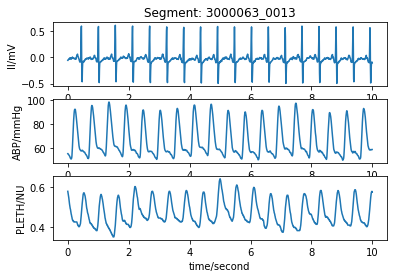

In [33]:
title_text = "Segment: " + rel_segment_name
wfdb.plot_wfdb(record=segment_data, title=title_text, time_units='seconds') 

<div class="alert alert-block alert-warning"> <b>Explanation:</b>
    This plot shows 10 seconds of data exracted from a longer segment. It contains three simultaneously recorded signals:
        <ul>
            <li> II: The ECG signal (lead II), measured in mV
            <li> ABP: The arterial blood pressure signal, measured in mmHg
            <li> PLETH: The photoplethysmogram (a.k.a PPG) signal, measured in (?) normalised units
        </ul>
</div>

- Extract the ABP signal

In [34]:
for sig_no in range(0,len(segment_data.sig_name)):
    if "ABP" in segment_data.sig_name[sig_no]:
        break
abp = segment_data.p_signal[:,sig_no]
fs = segment_data.fs
print("Extracted the ABP signal from column {} of the matrix of waveform data, and it's sampled at {} Hz.".format(sig_no, segment_data.fs))

Extracted the ABP signal from column 1 of the matrix of waveform data, and it's sampled at 125 Hz.


---

## Derive BP values
Derive BP values from the ABP signal

### Detect beats in the BP signal

- Import the functions required to detect beats (from [this file](https://github.com/wfdb/mimic_wfdb_tutorials/blob/main/content/tutorial/notebooks/beat_detection_functions.py)):

In [35]:
%run beat_detection_functions

- Detect beats in the ABP signal:

In [36]:
pks = pulse_detect(abp,fs,5,'delineator')
print("Detected {} beats in the ABP signal".format(len(pks)))

Detected 17 beats in the ABP signal


- Make a plot showing the ABP signal and the beats detected

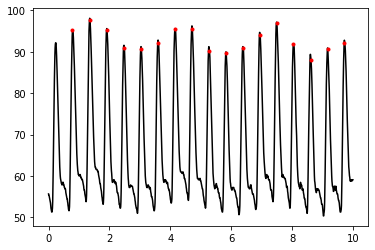

In [37]:
t = np.arange(0,(len(abp)/fs),1.0/fs)
line1 = plt.plot(t, abp, color = 'black', label='ABP')
line2 = plt.plot(t[0]+((pks-1)/fs), abp[pks], ".", color = 'red', label='peaks')

### Detect pulse onsets and peaks

- Import the functions required to detect fiducial points:

In [38]:
%run fiducial_point_functions

- Detect fiducial points:

In [39]:
fidp = fiducial_points(abp,pks,fs,vis = False)

- Plot the ABP signal and the pulse peaks and onsets:

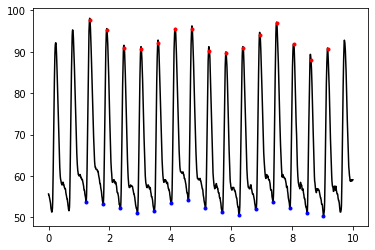

In [40]:
pks = fidp["pks"]
ons = fidp["ons"]
t = np.arange(0,(len(abp)/fs),1.0/fs)
plt.plot(t, abp, color = 'black')
plt.plot(t[pks], abp[pks], ".", color = 'red')
plt.plot(t[ons], abp[ons], ".", color = 'blue')

### Calculate BP values

- Extract systolic and diastolic BPs:

In [41]:
sbp = np.median(abp[fidp['pks']])
dbp = np.median(abp[fidp['ons']])

- Extract mean BPs:

In [42]:
ons = fidp['ons']
off = fidp['off']
mbps = np.zeros(len(ons))
for beat_no in range(0,len(ons)):
    mbps[beat_no] = np.mean(abp[ons[beat_no]:off[beat_no]])
mbp = np.median(mbps)

- Print results:

In [43]:
print('Systolic blood pressure  (SBP): {:.1f} mmHg'.format(sbp))
print('Diastolic blood pressure (DBP): {:.1f} mmHg'.format(dbp))
print('Mean blood pressure      (MBP): {:.1f} mmHg'.format(mbp))

Systolic blood pressure  (SBP): 91.9 mmHg
Diastolic blood pressure (DBP): 52.2 mmHg
Mean blood pressure      (MBP): 64.9 mmHg


<div class="alert alert-block alert-warning"> <b>Question:</b>
    Often MBP is approximated as: MBP = ((2/3)*DBP)+((1/3)*SBP).
    Would it have made much difference if we had used this approximation?
    What is the basis for this approximation?
</div>